IMPORTING IMPORTANT LIBRABIES 

In [3]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#importing important libraries
import pandas as pd
import PIL
import os
import matplotlib as plt
import cv2

In [6]:
#creating image list

img_dir = "/content/drive/MyDrive/facemaskdetection/images"
anno_dir = "/content/drive/MyDrive/facemaskdetection/annotations"

image_path = []
for img in os.listdir(img_dir):
    image = cv2.imread(os.path.join(img_dir,img),0)
    image_path.append(f'{img}')
    
# image_path

In [7]:
#creating a list of annotations with their path
anno_list = []
for x in os.listdir(anno_dir):
    anno_list.append(os.path.join(anno_dir,x))
    
# print(anno_list)

    

In [8]:
#extracting labels from annotation in dictonary

data = {'file_name':[],
        'height':[],
        'width':[],
        'labels':[],
        'x_min':[],
        'y_min':[],
        'x_max':[],
        'y_max':[]}

import xml.etree.ElementTree as ET

for anno in anno_list:
# anno = anno_list[0]
    tree = ET.parse(anno)
    root = tree.getroot()
    filename = ''
    width, height = [],[]
    for item in root.iter():
        if item.tag == 'filename':        #name of text file same as image name
            filename = item.text
        if item.tag == 'size':
            for atr in list(item):
                if atr.tag == 'width':
                    width = int(atr.text)
                if atr.tag == 'height':
                    height = int(atr.text)

        if item.tag == 'object':
            for atr in list(item):
                if atr.tag == 'name':
                    data['labels']+=[atr.text]
                    data['file_name'] += [filename]
                    data['width']+= [width]
                    data['height']+= [height]
                if atr.tag=='bndbox':                #bounding box
                    for bx in list(atr):
                        if bx.tag == 'xmin':
                            xmin = int(bx.text)
                            data['x_min'] += [xmin]
                        if bx.tag == 'ymin':
                            ymin = int(bx.text)
                            data['y_min']+= [ymin]
                        if bx.tag == 'xmax':
                            xmax = int(bx.text)
                            data['x_max']+= [xmax]
                        if bx.tag == 'ymax':
                            ymax = int(bx.text)
                            data['y_max'] += [ymax]
                            


In [9]:
#converting data from dictonary to dataframe

df = pd.DataFrame(data)
df.head()
df['labels'].unique()

array(['with_mask', 'without_mask', 'mask_weared_incorrect'], dtype=object)

In [10]:
#image output label converting to trainable data integer
labels_map = {'without_mask':0, 'with_mask' : 1, 'mask_weared_incorrect':2}
df['class'] = df['labels'].map(labels_map)

In [11]:
df.head()

,file_name,height,width,labels,x_min,y_min,x_max,y_max,class
0,maksssksksss103.png,300,400,with_mask,42,54,94,110,1
1,maksssksksss103.png,300,400,with_mask,188,46,236,106,1
2,maksssksksss103.png,300,400,with_mask,261,88,303,130,1
3,maksssksksss103.png,300,400,with_mask,368,112,400,151,1
4,maksssksksss102.png,225,400,with_mask,212,57,251,106,1


In [12]:
#spliting data into train, test, and validation data

from sklearn.model_selection import train_test_split
train , test = train_test_split(image_path,test_size=0.2, random_state=100)
train , val = train_test_split(train, test_size=0.2,random_state=100)

In [15]:
#cloning yolov5 from github
%cd /content/drive/MyDrive/facemaskdetection/
# yolo v5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

/content/drive/MyDrive/facemaskdetection
Cloning into 'yolov5'...
remote: Enumerating objects: 15705, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15705 (delta 9), reused 15 (delta 3), pack-reused 15672
Receiving objects: 100% (15705/15705), 14.51 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (10750/10750), done.
/content/drive/MyDrive/facemaskdetection/yolov5


In [16]:
#creating new directories in yolov5 folder for processing

os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/train')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/val')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/test')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/train/images')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/train/labels')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/val/images')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/val/labels')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/test/images')
os.mkdir('/content/drive/MyDrive/facemaskdetection/yolov5/data/test/labels')

In [17]:
# copyting images to respective yolov5 directories 

def copy_data(image_item, folder_name):
    for imag in image_item:
        img = PIL.Image.open(f'{img_dir}/{imag}')
        img1 = img.resize((640,480))                      #resizing images as common dimensions for easy training
        _ = img1.save(f'/content/drive/MyDrive/facemaskdetection/yolov5/data/{folder_name}/images/{imag}')
        


In [18]:
copy_data(test,'test')  #for test data 
copy_data(val,'val')    #for validation data
copy_data(train,'train')#for train data

In [19]:
#updating bounding boxes with respected change in size of images

df['x_min'] = (640/df['width']) * df['x_min']
df['y_min'] = (480/df['height']) * df['y_min']
df['x_max'] = (640/df['width']) * df['x_max']
df['y_max'] = (480/df['height']) * df['y_max']
df.head()

,file_name,height,width,labels,x_min,y_min,x_max,y_max,class
0,maksssksksss103.png,300,400,with_mask,67.2,86.4,150.4,176.000000,1
1,maksssksksss103.png,300,400,with_mask,300.8,73.6,377.6,169.600000,1
2,maksssksksss103.png,300,400,with_mask,417.6,140.8,484.8,208.000000,1
3,maksssksksss103.png,300,400,with_mask,588.8,179.2,640.0,241.600000,1
4,maksssksksss102.png,225,400,with_mask,339.2,121.6,401.6,226.133333,1


In [20]:
df.head()
df.file_name = [x.split('.')[0] for x in df.file_name]

df[['x_min','y_min','x_max','y_max']] = df[['x_min','y_min','x_max','y_max']].astype('int')

In [21]:
#updating box center with change in size of images

WIDTH = 640
HEIGHT = 480
df['x_center'] = (df['x_min']+df['x_max'])/(2*WIDTH)
df['y_center'] = (df['y_min']+df['y_max'])/(2*HEIGHT)
df['box_width'] = (df['x_max']-df['x_min'])/ WIDTH
df['box_height'] = (df['y_max']-df['y_min'])/ HEIGHT

In [22]:
df = df.astype('str')

In [23]:
image_path[:5]

['maksssksksss0.png',
 'maksssksksss1.png',
 'maksssksksss137.png',
 'maksssksksss114.png',
 'maksssksksss123.png']

In [24]:
#function for copyting annotation/ bounding box data to respective yolov5 directories

def copy_labels(lable_items, folder_name):
    file_name = [x.split('.')[0] for x in lable_items]
    print(file_name)
    for name in file_name:
        data = df[df.file_name == name]
        box_list = []
        
        for id in range(len(data)):
            row = data.iloc[id]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])
            text = "\n".join(box_list)
            with open(f'/content/drive/MyDrive/facemaskdetection/yolov5/data/{folder_name}/labels/{name}.txt','w') as file:
                file.write(text)
                

            

In [25]:
copy_labels(train,'train')   #for training data
copy_labels(val,'val')       #for validation data
copy_labels(test,'test')     #for test data

['maksssksksss171', 'maksssksksss161', 'maksssksksss368', 'maksssksksss275', 'maksssksksss440', 'maksssksksss478', 'maksssksksss464', 'maksssksksss348', 'maksssksksss815', 'maksssksksss119', 'maksssksksss782', 'maksssksksss596', 'maksssksksss695', 'maksssksksss341', 'maksssksksss658', 'maksssksksss169', 'maksssksksss419', 'maksssksksss580', 'maksssksksss126', 'maksssksksss609', 'maksssksksss612', 'maksssksksss88', 'maksssksksss578', 'maksssksksss225', 'maksssksksss530', 'maksssksksss402', 'maksssksksss117', 'maksssksksss173', 'maksssksksss264', 'maksssksksss131', 'maksssksksss335', 'maksssksksss53', 'maksssksksss281', 'maksssksksss412', 'maksssksksss408', 'maksssksksss826', 'maksssksksss633', 'maksssksksss668', 'maksssksksss372', 'maksssksksss707', 'maksssksksss563', 'maksssksksss762', 'maksssksksss589', 'maksssksksss188', 'maksssksksss796', 'maksssksksss35', 'maksssksksss83', 'maksssksksss394', 'maksssksksss457', 'maksssksksss193', 'maksssksksss850', 'maksssksksss551', 'maksssksksss54

In [26]:
#copying training and validation data paths to data.yaml for training

yaml_file = """train: /content/drive/MyDrive/facemaskdetection/yolov5/data/train/images
val: /content/drive/MyDrive/facemaskdetection/yolov5/data/val/images
                
nc: 3
names: [without_mask, with_mask, mask_weared_incorrect]"""

with open('/content/drive/MyDrive/facemaskdetection/yolov5/data/data.yaml', 'w') as f:
    f.write(yaml_file)

In [27]:
#training yolov5 for custom dataset

!python /content/drive/MyDrive/facemaskdetection/yolov5/train.py --img 640 --epochs 50 --batch 15 --data /content/drive/MyDrive/facemaskdetection/yolov5/data/data.yaml --cfg /content/drive/MyDrive/facemaskdetection/yolov5/models/yolov5s.yaml --weights yolov5s.pt --name mask_wearing_yolov5

train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/facemaskdetection/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/facemaskdetection/yolov5/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=15, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=mask_wearing_yolov5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_

In [4]:
from IPython.display import Image as Display

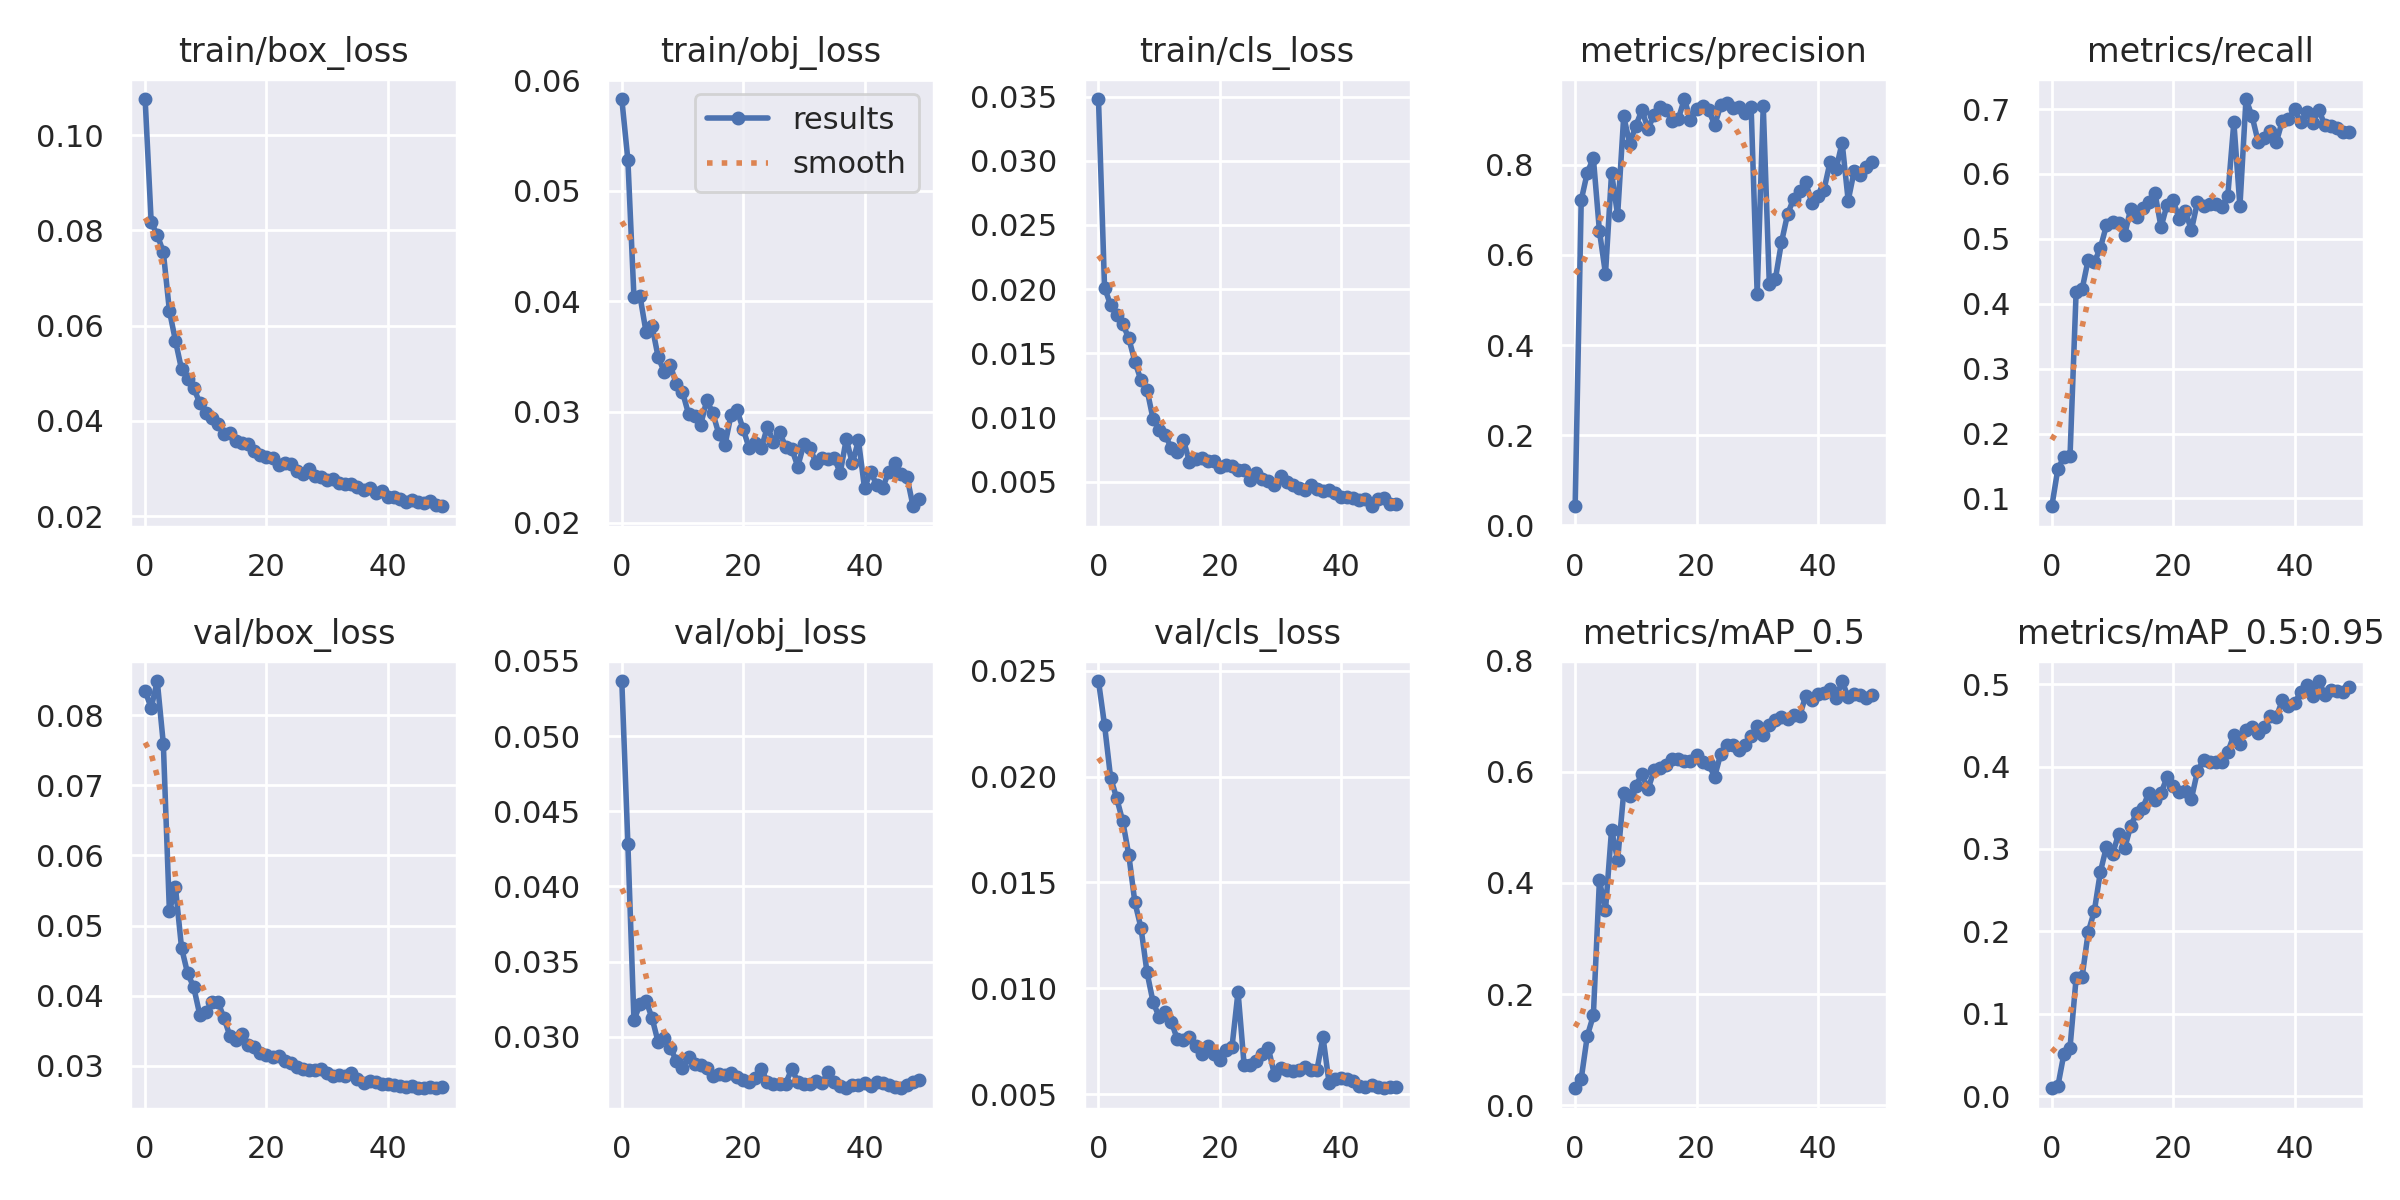

In [5]:
Display(filename='/content/drive/MyDrive/facemaskdetection/yolov5/runs/train/mask_wearing_yolov5/results.png', width=1080)

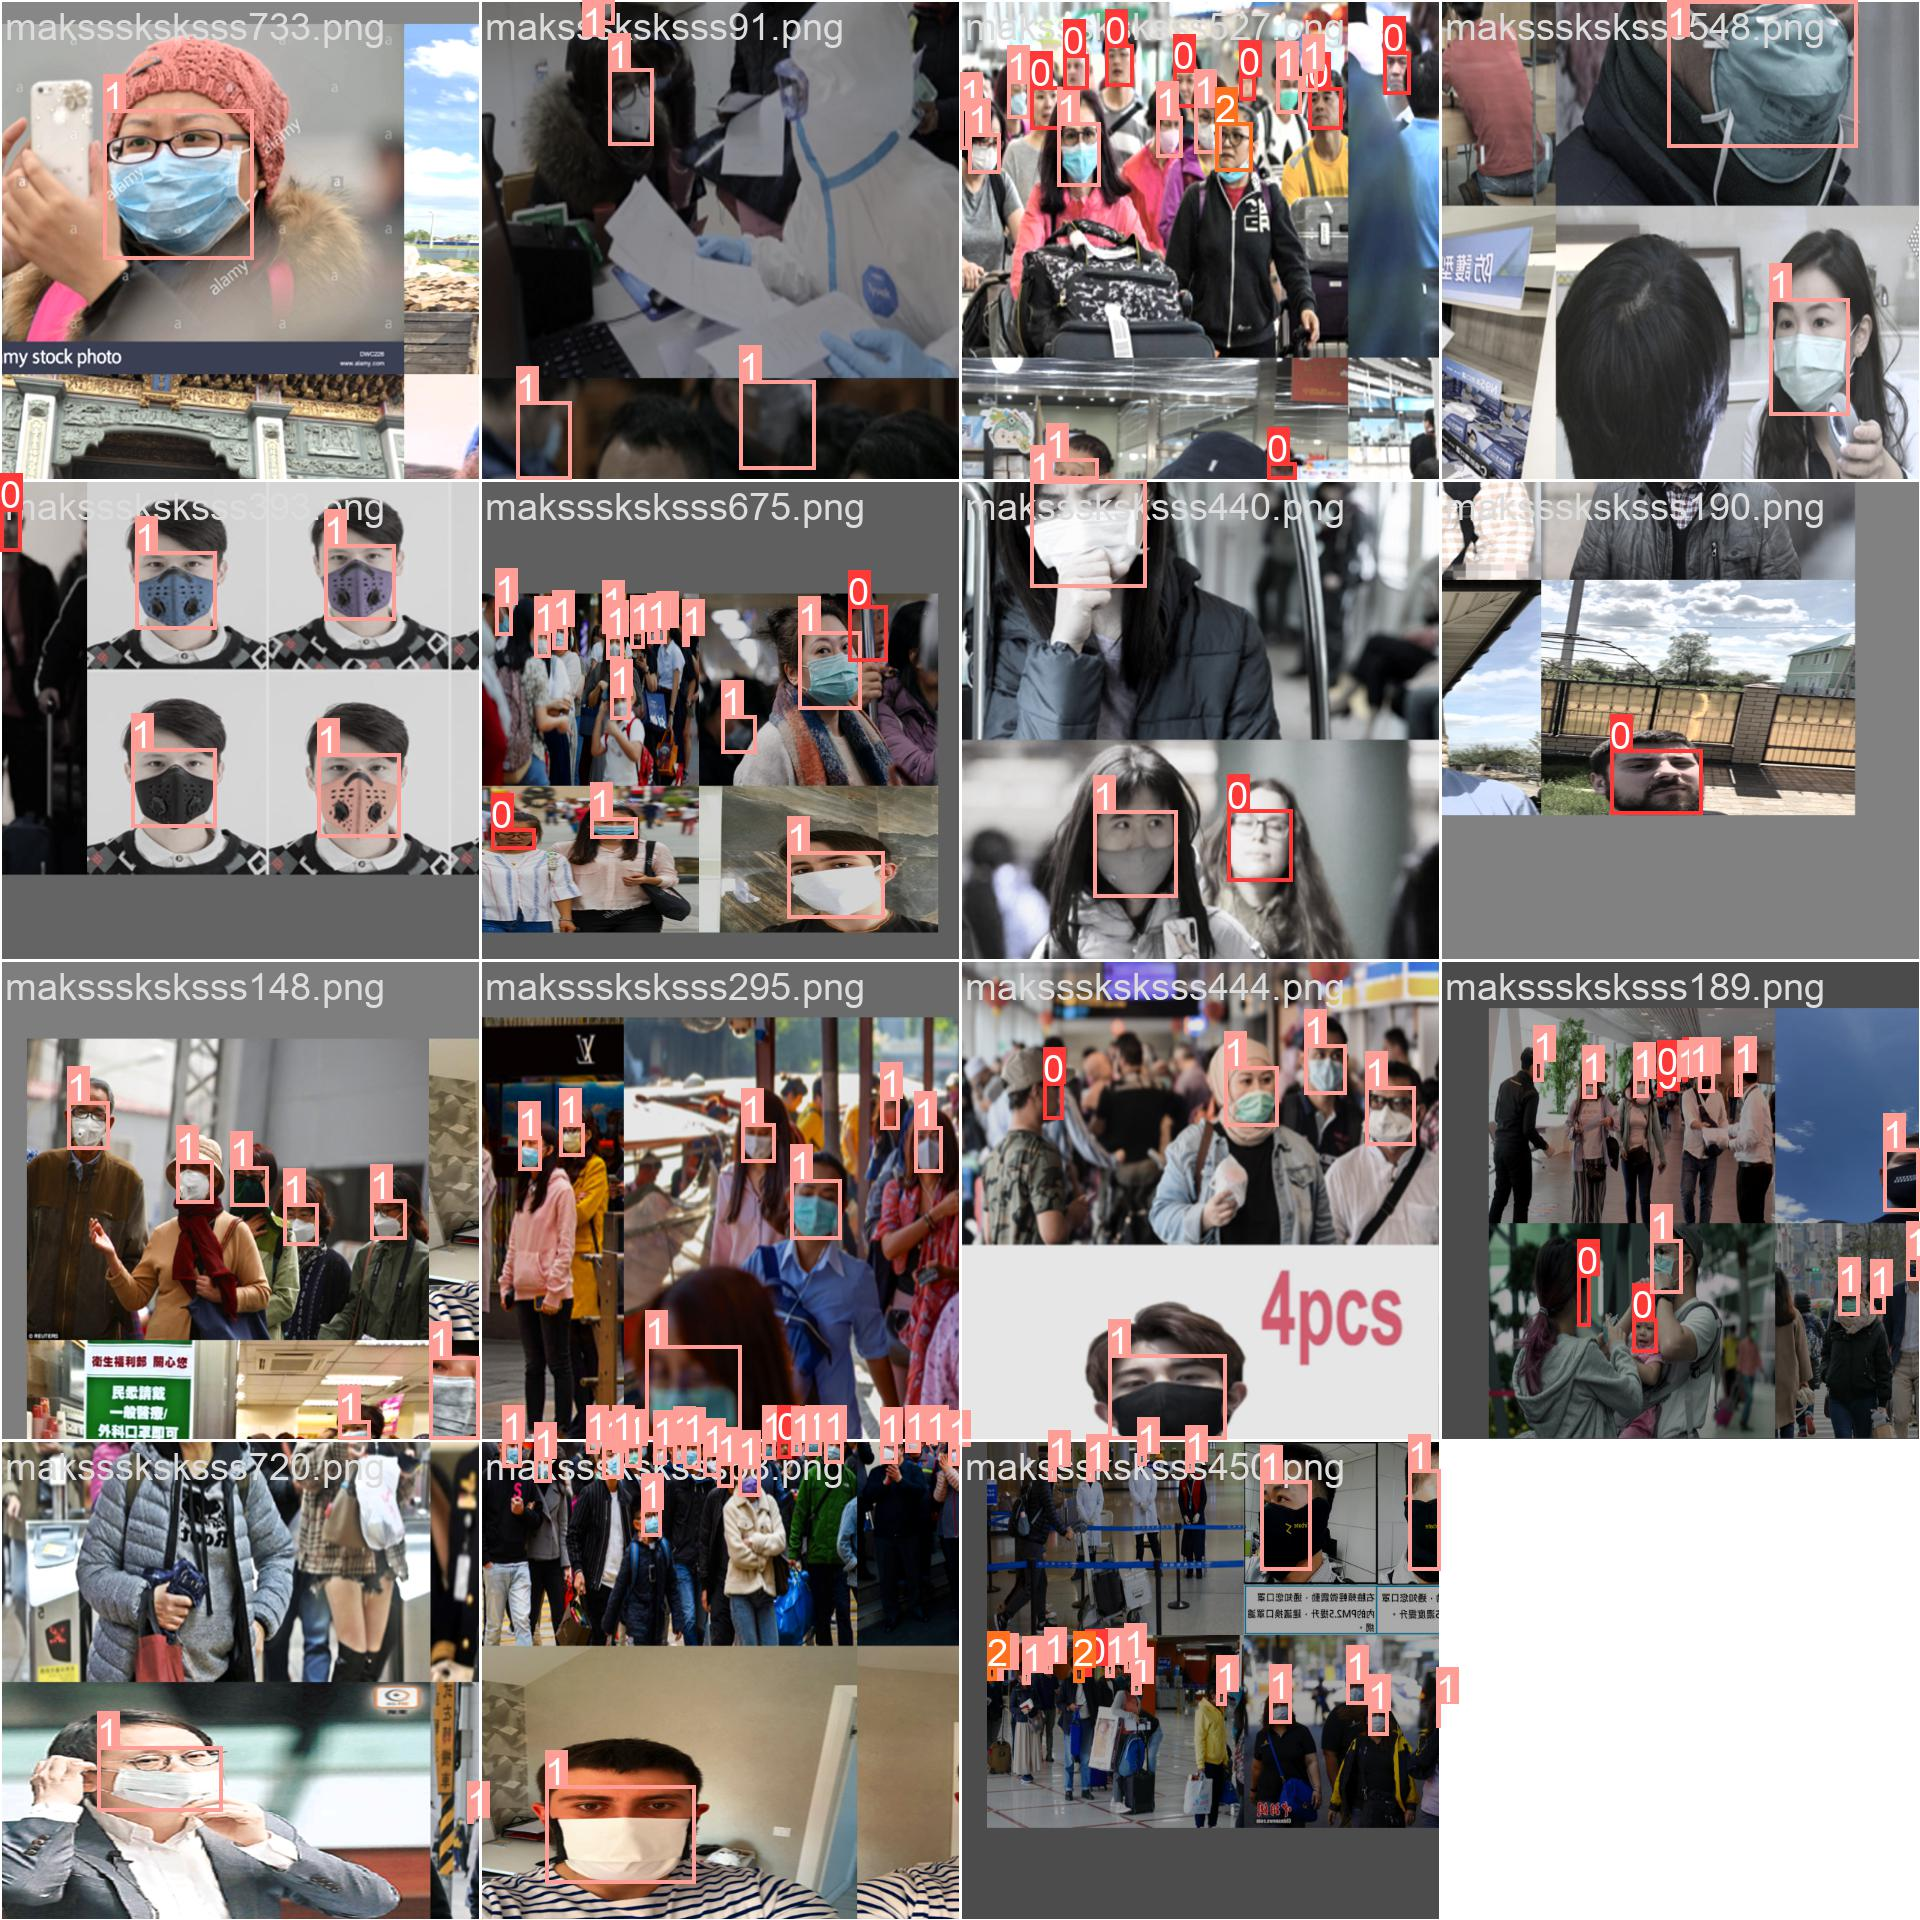

In [6]:
Display(filename='/content/drive/MyDrive/facemaskdetection/yolov5/runs/train/mask_wearing_yolov5/train_batch0.jpg', width=600)

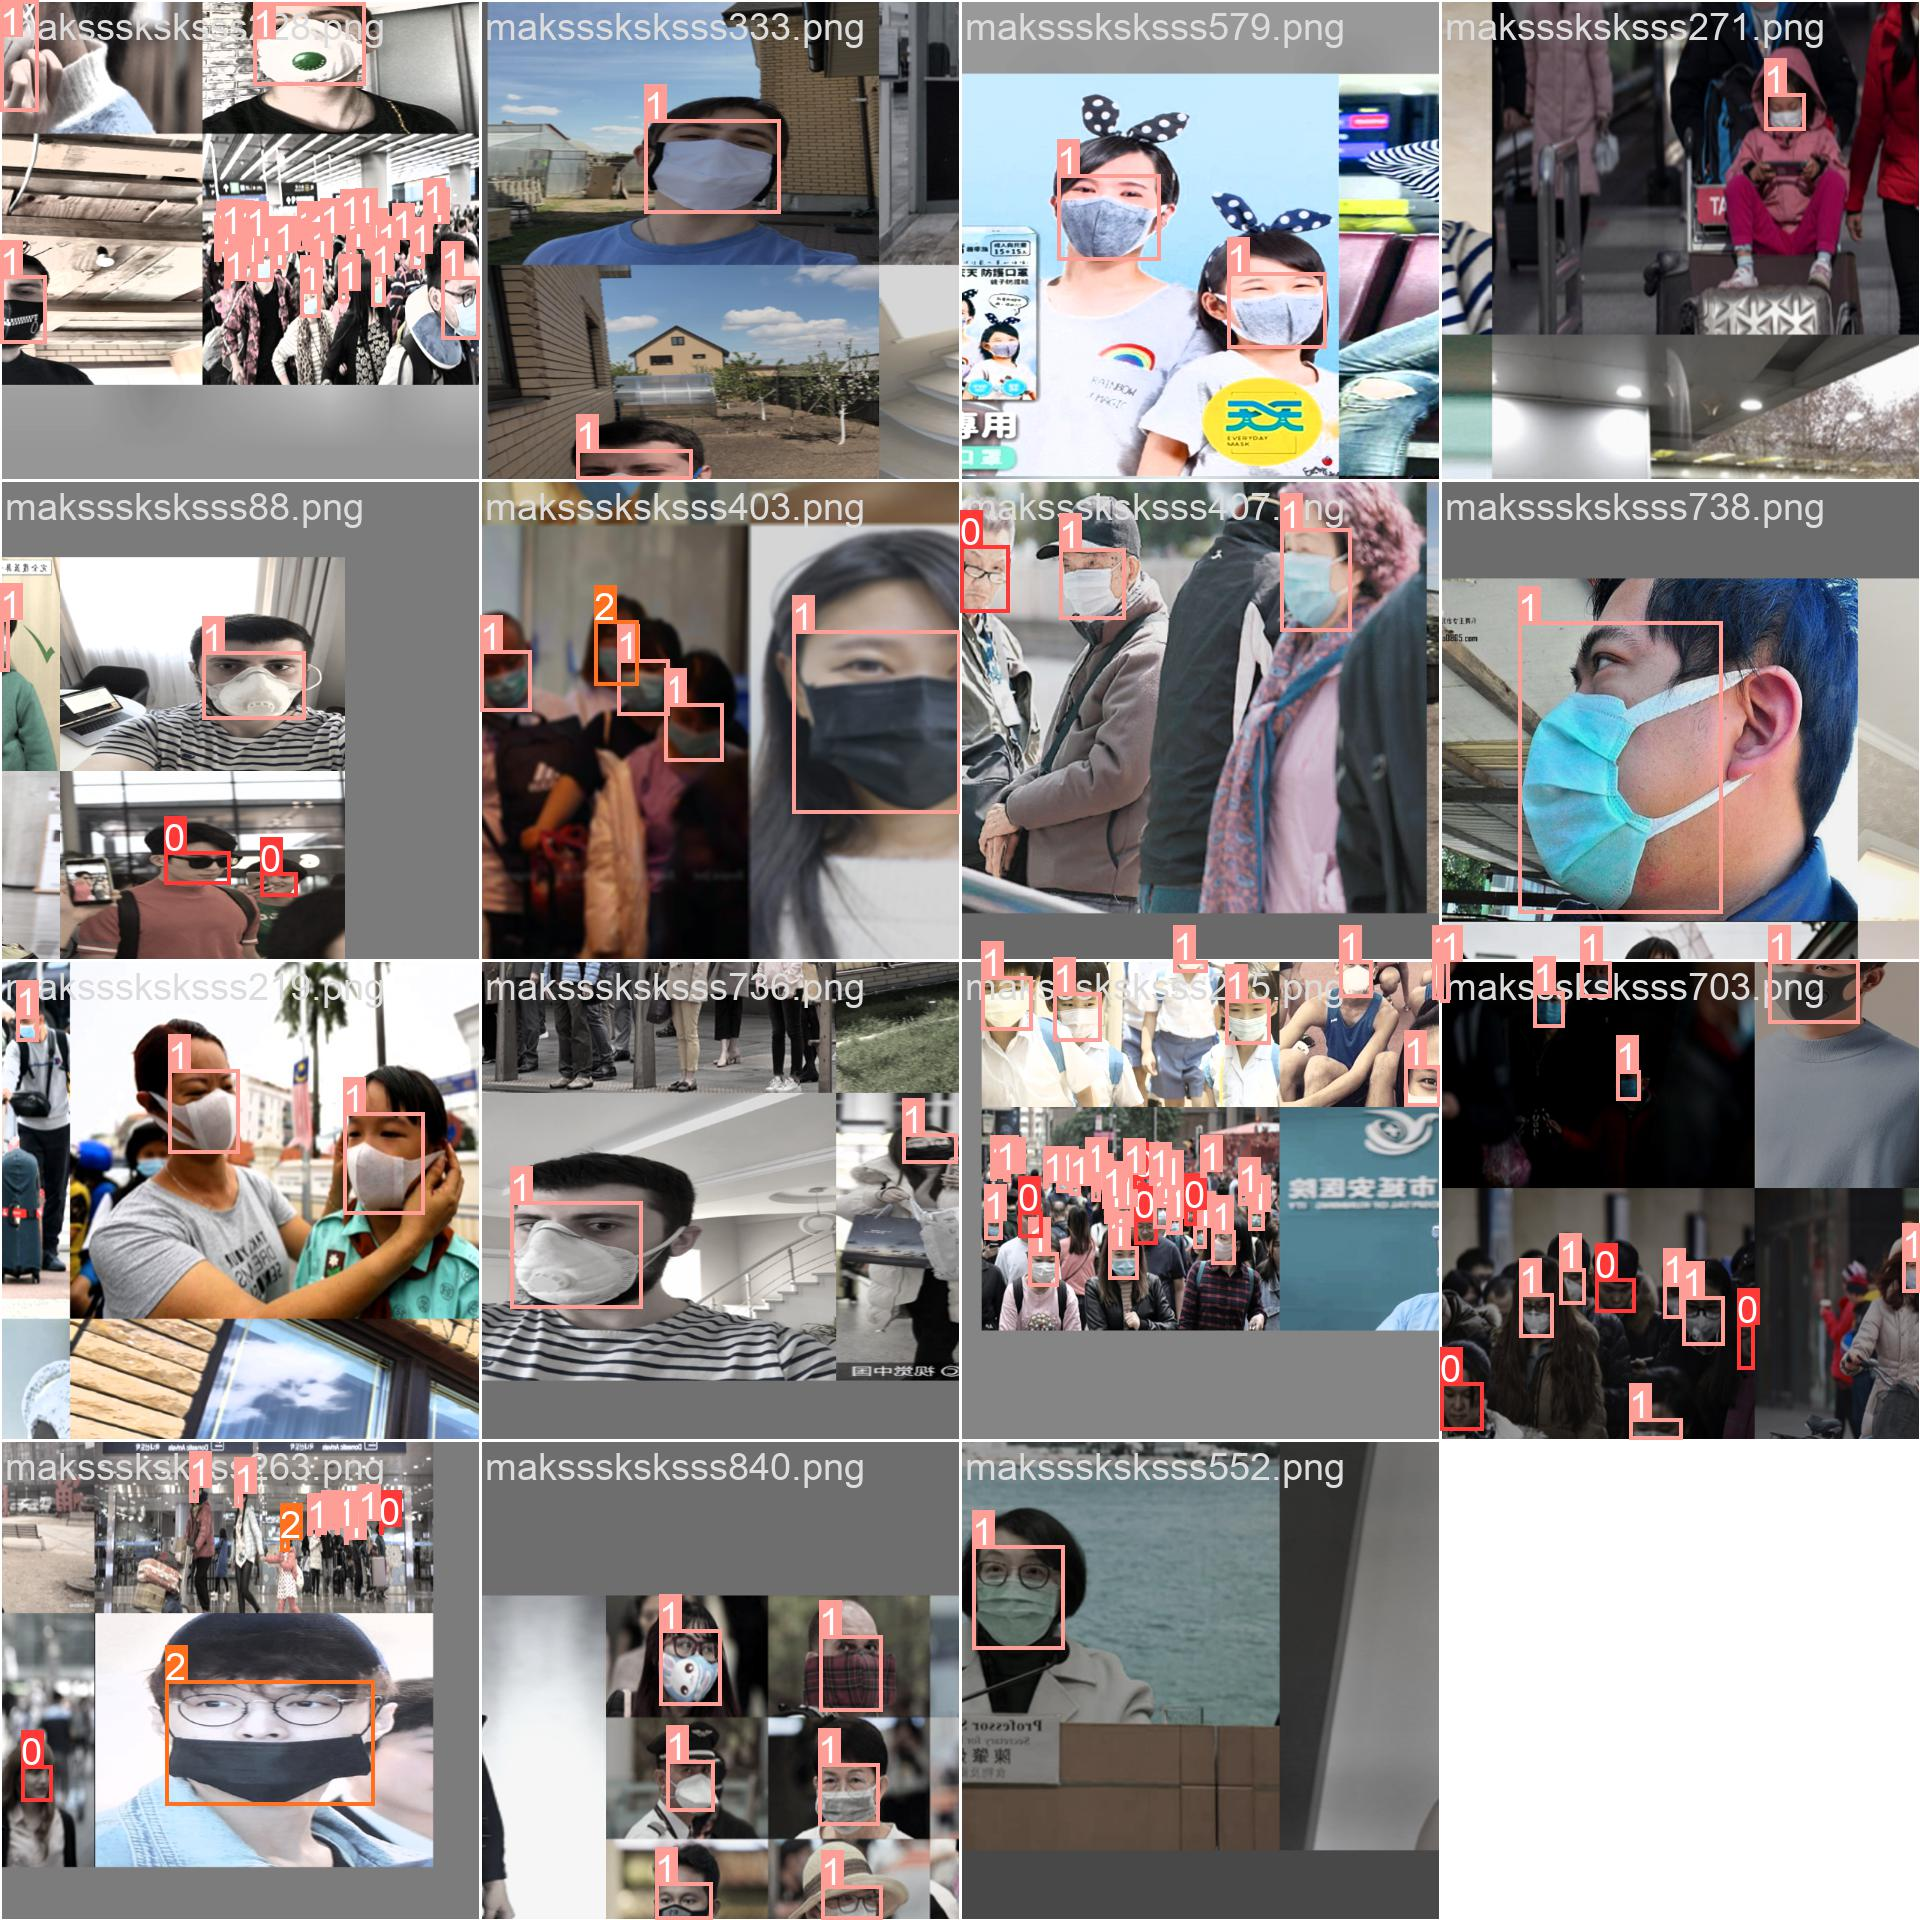

In [7]:
Display(filename='/content/drive/MyDrive/facemaskdetection/yolov5/runs/train/mask_wearing_yolov5/train_batch1.jpg', width=600)

In [ ]:
#detecting face mask using live webcam

 !python /content/drive/MyDrive/facemaskdetection/yolov5/detect.py --weights /content/drive/MyDrive/facemaskdetection/yolov5/runs/train/mask_wearing_yolov52/weights/bbbest.pt --source 0